In [1]:
# importing the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tkinter as tk
from tkinter import filedialog
import pathlib
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Flatten, Input, ZeroPadding2D, BatchNormalization
from keras.layers import Activation,MaxPooling2D, Add,AveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import tkinter


In [ ]:
# unzip the uploaded zip file to extrac the dataset
import zipfile as zf
files = zf.ZipFile('archive.zip')
files.extractall('Face Mask Detection')
files.close()

In [2]:
# Fetching the dataset
data = 'Train'
data = pathlib.Path(data)

In [3]:
# Data preprocessing for Training Set
batch_size=16
height = 64
width = 64

train_data=tf.keras.utils.image_dataset_from_directory(
    data,
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(height,width)
)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.


In [4]:
# Data preprocessing for Validation Set
valid_data=tf.keras.utils.image_dataset_from_directory(
    data,
    batch_size=batch_size,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(height,width)
)

Found 10000 files belonging to 2 classes.
Using 2000 files for validation.


In [5]:
# Sowing the classes in Train Set
train_label_name = train_data.class_names
print(train_label_name)

['WithMask', 'WithoutMask']


In [6]:
# Sowing the classes in Validation Set
valid_label_name = valid_data.class_names
print(valid_label_name)

['WithMask', 'WithoutMask']


In [7]:
# Automatically shuffling the images @ 1000 images per fetch
autotune=tf.data.experimental.AUTOTUNE
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=autotune)

valid_data=valid_data.cache().prefetch(buffer_size=autotune)

In [8]:
def identity_block(X, f, filters):
  F1, F2, F3 = filters

  X_shortcut = X
  
  X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X)

  X = Add()([X,X_shortcut])
  X = Activation('relu')(X)

  return X

In [9]:
def convolutional_block(X, f, filters, s=2):
  
  F1, F2, F3 = filters

  X_shortcut = X

  X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters = F2, kernel_size = (1,1), strides = (1,1), padding = 'same')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid')(X)
  X = BatchNormalization(axis = 3)(X)

  X_shortcut = Conv2D(filters = F3, kernel_size = (1,1), strides = (s,s), padding = 'valid')(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [10]:
# Building the ResNet50 using identity block and convolutional block
def ResNet50(input_shape=(height, width, 3), classes = 2):

  X_input = Input(input_shape)

  X = ZeroPadding2D(padding = (3,3))(X_input)

  X = Conv2D(filters = 64, kernel_size = (7,7), strides = (2,2))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  
  X = MaxPooling2D(pool_size = (3,3), strides = (2,2))(X)

  X = convolutional_block(X, f = 3, filters = [64,64,256], s = 1)
  X = identity_block(X, f = 3, filters = [64,64,256])
  X = identity_block(X, f = 3, filters = [64,64,256])

  X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
  X = identity_block(X, f = 3, filters = [128,128,512])
  X = identity_block(X, f = 3, filters = [128,128,512])
  X = identity_block(X, f = 3, filters = [128,128,512])

  X = convolutional_block(X, f = 3, filters = [256,256,1024], s = 2)
  X = identity_block(X, f = 3, filters = [256,256,1024])
  X = identity_block(X, f = 3, filters = [256,256,1024])
  X = identity_block(X, f = 3, filters = [256,256,1024])
  X = identity_block(X, f = 3, filters = [256,256,1024])
  X = identity_block(X, f = 3, filters = [256,256,1024])

  X = convolutional_block(X, f = 3, filters = [512,512,2048], s = 2)
  X = identity_block(X, f = 3, filters = [512,512,2048])
  X = identity_block(X, f = 3, filters = [512,512,2048])

  X = AveragePooling2D(pool_size = (2,2), name = 'avg_pool')(X)

  X = Flatten()(X)
  X = Dense(1, activation = 'sigmoid')(X)

  model = Model(inputs = X_input, outputs = X, name = 'ResNet50')

  return model

In [11]:
resnet_50_model = ResNet50(input_shape = (height,width,3), classes = 2)

In [12]:
resnet_50_model.compile(Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [13]:
resnet_50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

 conv2d_10 (Conv2D)             (None, 15, 15, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 15, 15, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_2 (Add)                    (None, 15, 15, 256)  0           ['batch_normalization_10[0][0]', 
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 15, 15, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_11

                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 512)    0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_21 (Conv2D)             (None, 8, 8, 128)    65664       ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 8, 8, 128)   512         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 8, 8, 128)    0           ['batch_normalization_21[0][0]'] 
          

 batch_normalization_31 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_28 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_32 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_42 (Conv2D)             (None, 4, 4, 1024)   263168      ['activation_38[0][0]']          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 4, 4, 1024)  4096        ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_12 (Add)                   (None, 4, 4, 1024)   0           ['batch_normalization_42[0][0]', 
                                                                  'activation_36[0][0]']          
                                                                                                  
 activation_39 (Activation)     (None, 4, 4, 1024)   0           ['add_12[0][0]']                 
          

 add_15 (Add)                   (None, 2, 2, 2048)   0           ['batch_normalization_52[0][0]', 
                                                                  'activation_45[0][0]']          
                                                                                                  
 activation_48 (Activation)     (None, 2, 2, 2048)   0           ['add_15[0][0]']                 
                                                                                                  
 avg_pool (AveragePooling2D)    (None, 1, 1, 2048)   0           ['activation_48[0][0]']          
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['avg_pool[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 1)            2049        ['flatten[0][0]']                
          

In [14]:
# Total no. of iterations to be carried out during training
noepochs = 7

In [15]:
# Running the epochs on ResNet50 model
mymodel=resnet_50_model.fit(train_data,validation_data=valid_data,epochs=noepochs)

Epoch 1/7
500/500 [==============================] - 769s 2s/step - loss: 0.2227 - accuracy: 0.9249 - val_loss: 0.1624 - val_accuracy: 0.9425
Epoch 2/7
500/500 [==============================] - 755s 2s/step - loss: 0.0712 - accuracy: 0.9771 - val_loss: 0.2213 - val_accuracy: 0.8915
Epoch 3/7
500/500 [==============================] - 760s 2s/step - loss: 0.0633 - accuracy: 0.9801 - val_loss: 0.7896 - val_accuracy: 0.7340
Epoch 4/7
500/500 [==============================] - 760s 2s/step - loss: 0.0374 - accuracy: 0.9871 - val_loss: 0.0608 - val_accuracy: 0.9815
Epoch 5/7
500/500 [==============================] - 767s 2s/step - loss: 0.0444 - accuracy: 0.9854 - val_loss: 0.0400 - val_accuracy: 0.9855
Epoch 6/7
500/500 [==============================] - 736s 1s/step - loss: 0.0379 - accuracy: 0.9871 - val_loss: 0.1014 - val_accuracy: 0.9665
Epoch 7/7
500/500 [==============================] - 734s 1s/step - loss: 0.0344 - accuracy: 0.9875 - val_loss: 0.0950 - val_accuracy: 0.9680


In [16]:
epoch_range=range(noepochs)
acc=mymodel.history['accuracy']
val_acc = mymodel.history['val_accuracy']
loss=mymodel.history['loss'] 
val_loss=mymodel.history['val_loss']

Text(0.5, 1.0, 'Training and validation Accuracy')

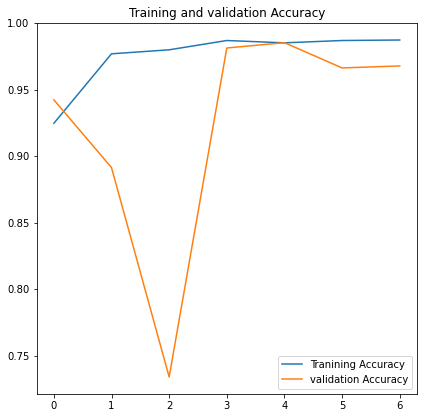

In [17]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,2)
plt.plot(epoch_range,acc,label='Tranining Accuracy')
plt.plot(epoch_range,val_acc,label='validation Accuracy')
plt.legend(loc ="lower right")
plt.title("Training and validation Accuracy")

Text(0.5, 1.0, 'Training and validation loss')

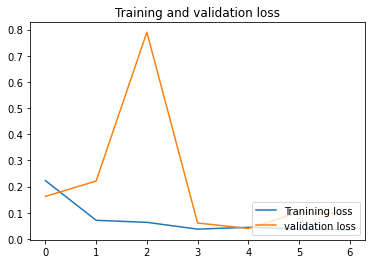

In [18]:
plt.subplot(1,1,1)
plt.plot(epoch_range,loss,label='Tranining loss')
plt.plot(epoch_range,val_loss,label='validation loss')
plt.legend(loc ="lower right")
plt.title("Training and validation loss")

In [ ]:
def recogout():
    root=tk.Tk()
    root.withdraw()
    img_path=filedialog.askopenfilename()
    img=keras.preprocessing.image.load_img(img_path,target_size=(height,width))
    img_array=keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print("this image most likely belong to {}with a{:.2f} prcent confidence."
         .format(class_names[np.argmax(score)],100*np.max(score)))

In [ ]:
recogout()

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.
